# Sistemas de recomendación

Aplicado a un dataset de películas

# 0. Preparación previa

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors

In [118]:
mainpath = "/Users/irene/Documents/GitHub/python-ml-course/datasets"  #Ruta ficheros
filename = "ml-100k/u.data.csv" #Fichero a abrir
fullpath = mainpath + "/" + filename #Ruta completa

column_names = ['User ID', 'Movie ID', 'Rating', 'TimeStamp']

df = pd.read_csv(fullpath, sep="\t", header=None, names = column_names)
print(df.shape) #tamaño dataset

df.head()

(100000, 4)


,User ID,Movie ID,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# 1. Sistema de recomendación

## 1.1. Análisis exploratorio de los datos

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

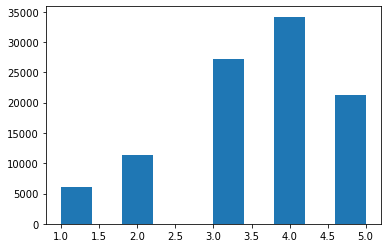

In [119]:
plt.hist(df.Rating) #Para ver cómo se distribuyen las valoraciones

In [120]:
df.groupby([df.Rating])["User ID"].count() #Cuántos usuarios han votado cada una de ellas, es lo mismo que el histograma anterior

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: User ID, dtype: int64

(array([1.146e+03, 2.490e+02, 1.390e+02, 6.700e+01, 3.800e+01, 2.400e+01,
        7.000e+00, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([  1. ,  59.2, 117.4, 175.6, 233.8, 292. , 350.2, 408.4, 466.6,
        524.8, 583. ]),
 <BarContainer object of 10 artists>)

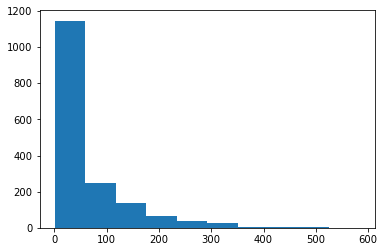

In [121]:
plt.hist(df.groupby(["Movie ID"])["Movie ID"].count()) #Hay películas que han sido más vistas que otras

## 1.2. Representación en forma matricial

Necesitamos tener una matriz de recomendaciones, donde filas = usuarios, y columnas = películas, la combinación de ambas es el rating que ha dado ese usuario a esa película

In [122]:
#1ero averiguamos cuántos usuarios únicos hay

n_users = df["User ID"].unique().shape[0]
n_movies = df["Movie ID"].unique().shape[0]

print("El nº de usuarios es de: " + str(n_users))
print("El nº de películas es de: " + str(n_movies))

El nº de usuarios es de: 943
El nº de películas es de: 1682


In [123]:
#matriz de valoraciones con 0's

ratings = np.zeros((n_users,n_movies))
ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [124]:
for row in df.itertuples(): #por cada fila dentro del dataframe original
    ratings[row[1]-1, row[2]-1] = row[3] #empezamos en 0
    
ratings #encontramos una matriz llena de 0's, se les llama matriz spars

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [125]:
#determinamos el coeficiente de sparseidad, es decir, qué % de la matriz NO tiene 0's

sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0]*ratings.shape[1]) #dividimos por la longitud del array
sparsity *= 100
print("Coeficiente de sparseidad: {:4.2f}%".format(sparsity))

Coeficiente de sparseidad: 6.30%


## 1.3. Creamos subconjuntos de entrenamiento y validación

De la matriz de recomendaciones

In [126]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.3, random_state=42) #30%

print("Tenemos un dataset para entrenar de tamaño: " + str(ratings_train.shape))
print("Tenemos un dataset para testear de tamaño: " + str(ratings_test.shape))

Tenemos un dataset para entrenar de tamaño: (660, 1682)
Tenemos un dataset para testear de tamaño: (283, 1682)


## 1.4 Filtro colaborativo
### 1.4.1. Basado en Usuarios

Para un usuario x, del que conocemos [las pelis que ha visto] y [la valoración que les ha dado] -> 
1. Buscamos usuarios similares -> que hayan visto pelis con valoración similar (para ello usaremos la distancia coseno)
2. Haremos una suma ponderada de las pelis de esos usuarios para elegir la peli a recomendar.

* Matriz de similaridad entre los usuarios (distancia del coseno, que da siempre valores entre 0 y 1) y cogemos los k vecinos + cercanos -> 0 es que son muy parecidos, 1 es que son muy diferentes. 
** Cambiamos los 0's por 1's para que sea más claro
* Predecir la valoración desconocida de un ítem *i* para un usuario activo *u* basándonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem.
* Recomendaremos los nuevos ítems a los usuarios según lo establecido en los pasos anteriores.

#### 1. Matriz de similaridades

In [127]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_test)
sim_matrix #se comparan los usuarios contra sí mismos

array([[1.        , 0.01775916, 0.        , ..., 0.28350676, 0.16604346,
        0.        ],
       [0.01775916, 1.        , 0.10949965, ..., 0.09149486, 0.10727161,
        0.29149166],
       [0.        , 0.10949965, 1.        , ..., 0.08713681, 0.        ,
        0.28879086],
       ...,
       [0.28350676, 0.09149486, 0.08713681, ..., 1.        , 0.19793486,
        0.03893564],
       [0.16604346, 0.10727161, 0.        , ..., 0.19793486, 1.        ,
        0.07977195],
       [0.        , 0.29149166, 0.28879086, ..., 0.03893564, 0.07977195,
        1.        ]])

Ponderamos la matriz de distancias por los ratings para obtener las predicciones de las valoraciones que los usuarios harían a cada película.

In [128]:
#.dot = producto matricial

users_predictions = sim_matrix.dot(ratings_test) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
users_predictions

array([[2.47537469e+00, 7.01507002e-01, 3.70391107e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.73649392e+00, 2.54530419e-01, 2.29995340e-01, ...,
        9.19630908e-03, 0.00000000e+00, 0.00000000e+00],
       [1.27891613e+00, 2.42958428e-01, 1.52385690e-01, ...,
        1.99425992e-02, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.32444820e+00, 6.51072887e-01, 3.72683157e-01, ...,
        1.27657170e-03, 0.00000000e+00, 0.00000000e+00],
       [2.03330183e+00, 4.94112870e-01, 3.04957161e-01, ...,
        2.90605858e-03, 0.00000000e+00, 0.00000000e+00],
       [1.03844171e+00, 2.22612289e-01, 1.27654854e-01, ...,
        2.03317109e-02, 0.00000000e+00, 0.00000000e+00]])

In [129]:
#Calculamos el error cuadrático restando las predicciones a los valores originales que no fueran 0

def get_mse(preds, actuals): #predicciones y actuales
    if preds.shape[0] != actuals.shape[0]: #nos quedamos con los que no eran 0
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten() #con flatten pasamos a vector
    actuals = actuals[actuals.nonzero()].flatten() 
    return mean_squared_error(preds, actuals)

In [130]:
get_mse(users_predictions, ratings_test)

7.51355110112698

### 1.4.3. Basado en los KNN

En el ejercicio anterior hemos tomado en cuenta TODOS los usuarios, ahora no, sólo consideramos los usuarios top k más similares

In [131]:
k = 10 #top10

In [137]:
neighbors = NearestNeighbors(n_neighbors=k, metric='cosine') #usamos la similaridad del coseno
neighbors.fit(ratings_train)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [145]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)

#Transformar las distancias en similitudes para ponderar
top_k_sim = 1 - top_k_distances

print("Los usuarios más cercanos al usuario 0 son: ")
print(top_k_users[0])

print("Las distancias con estos usuarios son: ")
print(top_k_sim[0])

Los usuarios más cercanos al usuario 0 son: 
[  0 211  16 185 101 155 169 407 112 618]
Las distancias con estos usuarios son: 
[1.         0.50219252 0.44215162 0.43034415 0.42836379 0.42479412
 0.41794826 0.40773919 0.40501374 0.39989837]


In [158]:
#Ponderamos las valoraciones solo de los k_users
users_predicts_k = np.zeros(ratings_train.shape) #matriz de 0's
users_predicts_k.shape

for i in range(ratings_train.shape[0]):# para cada usuario del conjunto de entrenamiento
    users_predicts_k[i,:] = top_k_sim[i].dot(ratings_train[top_k_users[i]]) / np.sum(top_k_sim[i]) #dividimos para normalizar

In [147]:
get_mse(users_predicts_k, ratings_train) #El error cuadrático medio mejora

2.7564466890655055

Usamos el modelo KKN entrenado con el conjunto de entrenamiento para obtener los k vecinos + cercanos del conjunto de test:

In [149]:
top_k_distances_test, top_k_users_test = neighbors.kneighbors(ratings_test)

#Definir las similitudes asociadas
top_k_sim_test = 1 - top_k_distances_test

#Obtener las predicciones del conjunto de test:

user_predicts_test_k = np.zeros(ratings_test.shape)

for i in range(ratings_test.shape[0]):
    user_predicts_test_k[i,:] = top_k_sim_test[i].dot(ratings_train[top_k_users_test[i]]) / np.sum(top_k_sim_test[i])
    
#Obtener el error del conjunto de test:

get_mse(user_predicts_test_k, ratings_test)

4.102396284374268

### 1.4.3. Basado en Películas (ítems)

En lugar de basado en personas, nos basamos en las similaridades entre pelis

In [159]:
n_movies = ratings_train.shape[1]
n_movies #nº de películas

1682

In [164]:
neighbors = NearestNeighbors(n_neighbors=n_movies, metric='cosine')
neighbors.fit(ratings_train.T)


top_k_distances, top_k_movies = neighbors.kneighbors(ratings_train.T, return_distance=True)

#Transformar las distancias en similitudes para ponderar
top_k_sim = 1 - top_k_distances

print("Las pelis más cercanas a la peli 0 son: ")
print(top_k_movies[0])

print("Las distancias con estos usuarios son: ")
print(top_k_sim[0])

Las pelis más cercanas a la peli 0 son: 
[   0   49  180 ... 1589 1602 1679]
Las distancias con estos usuarios son: 
[1.         0.72370191 0.69886672 ... 0.         0.         0.        ]


In [167]:
item_preds = ratings_train.dot(top_k_sim) / np.array([np.abs(top_k_sim).sum(axis=1)])

get_mse(item_preds, ratings_train)

<ipython-input-167-07c150a4ab27>:1: RuntimeWarning: divide by zero encountered in true_divide
  item_preds = ratings_train.dot(top_k_sim) / np.array([np.abs(top_k_sim).sum(axis=1)])
<ipython-input-167-07c150a4ab27>:1: RuntimeWarning: invalid value encountered in true_divide
  item_preds = ratings_train.dot(top_k_sim) / np.array([np.abs(top_k_sim).sum(axis=1)])


9.581847066551608

### Filtrado colaborativo basado en KNN

In [170]:
k = 30
neighbors = NearestNeighbors(k, metric='cosine')
neighbors.fit(ratings_train.T)
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_neighbors=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [ ]:
preds = np.zeros(ratings_train.T.shape)
for i in range(ratings_train.T.shape[0]):
    if(i%50==0):
        print("iter "+str(i))
    den = 1
    if (np.abs(top_k_distances[i]).sum(axis=0)>0):
        den = np.abs(top_k_distances[i]).sum(axis=0)
    preds[i, :] = top_k_distances[i].dot(ratings_train.T[top_k_items][i])/np.array([den]).T

iter 0
iter 50
iter 100
iter 150
iter 200
iter 250
iter 300
iter 350
iter 400
iter 450
iter 500
iter 550
iter 600
iter 650
iter 700
iter 750
iter 800
iter 850
iter 900
iter 950
iter 1000
iter 1050


In [ ]:
get_mse(preds, ratings_train.T)